<h3>I learned about creating and tuning ML pipeline</h3>

In [2]:
# Start Spark Session

import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

In [7]:
from pyspark.ml.feature import VectorAssembler

In [3]:
spark = SparkSession.builder \
        .master('local') \
        .appName('Air BnB Price') \
        .getOrCreate()

In [5]:
# Load dataset

filePath = 'data/sf-airbnb/sf-airbnb-clean.parquet'
airbnbDF = spark.read.parquet(filePath)

# See some columns
airbnbDF.select('neighbourhood_cleansed', 'room_type', 'bedrooms', 'bathrooms', 'number_of_reviews', 'price')\
        .show(5)

+----------------------+---------------+--------+---------+-----------------+-----+
|neighbourhood_cleansed|      room_type|bedrooms|bathrooms|number_of_reviews|price|
+----------------------+---------------+--------+---------+-----------------+-----+
|      Western Addition|Entire home/apt|     1.0|      1.0|            180.0|170.0|
|        Bernal Heights|Entire home/apt|     2.0|      1.0|            111.0|235.0|
|        Haight Ashbury|   Private room|     1.0|      4.0|             17.0| 65.0|
|        Haight Ashbury|   Private room|     1.0|      4.0|              8.0| 65.0|
|      Western Addition|Entire home/apt|     2.0|      1.5|             27.0|785.0|
+----------------------+---------------+--------+---------+-----------------+-----+
only showing top 5 rows



In [11]:
airbnbDF.printSchema()

root
 |-- host_is_superhost: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- host_total_listings_count: double (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- minimum_nights: double (nullable = true)
 |-- number_of_reviews: double (nullable = true)
 |-- review_scores_rating: double (nullable = true)
 |-- review_scores_accuracy: double (nullable = true)
 |-- review_scores_cleanliness: double (nullable = true)
 |-- review_scores_checkin: double (nullable = true)
 |-- review_scores_communication: double (nullable = true

In [6]:
# Creating Training and Test Data sets
trainDF, testDF = airbnbDF.randomSplit([0.8, 0.2], seed = 42)

print(f'There are {trainDF.count()} rows in the training set, and {testDF.count()} in the test set')

There are 5780 rows in the training set, and 1366 in the test set


In [34]:
# Preparing features with transformers

vecAssembler = VectorAssembler(inputCols=['bedrooms'], outputCol='features')

# To see the result of vector assembler
vecTrainDF = vecAssembler.transform(trainDF)
vecTrainDF.select('bedrooms', 'beds', 'features', 'price').show(5)

+--------+----+--------+-----+
|bedrooms|beds|features|price|
+--------+----+--------+-----+
|     1.0| 1.0|   [1.0]|200.0|
|     1.0| 1.0|   [1.0]|130.0|
|     1.0| 3.0|   [1.0]| 95.0|
|     1.0| 1.0|   [1.0]|250.0|
|     3.0| 3.0|   [3.0]|250.0|
+--------+----+--------+-----+
only showing top 5 rows



In [35]:
# Linear Regression with MLlib
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='price')

In [36]:
# Pipeline
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[vecAssembler, lr])
pipelineModel = pipeline.fit(trainDF)

In [37]:
predDF = pipelineModel.transform(testDF)
predDF.select('features', 'price', 'prediction').show(10)

+--------+------+------------------+
|features| price|        prediction|
+--------+------+------------------+
|   [1.0]|  85.0|171.18598011578285|
|   [1.0]|  45.0|171.18598011578285|
|   [1.0]|  70.0|171.18598011578285|
|   [1.0]| 128.0|171.18598011578285|
|   [1.0]| 159.0|171.18598011578285|
|   [2.0]| 250.0|294.86172649777757|
|   [1.0]|  99.0|171.18598011578285|
|   [1.0]|  95.0|171.18598011578285|
|   [1.0]| 100.0|171.18598011578285|
|   [1.0]|2010.0|171.18598011578285|
+--------+------+------------------+
only showing top 10 rows



In [38]:
# Evaluate our model
from pyspark.ml.evaluation import RegressionEvaluator

regressionEvaluator = RegressionEvaluator(
                        predictionCol = 'prediction',
                        labelCol = 'price',
                        metricName = 'rmse'
                        )

rmse = regressionEvaluator.evaluate(predDF)


print(f'RMSE is {rmse}')

RMSE is 221.62781635662907


In [40]:
slope = pipelineModel.stages[1].coefficients
intercept = pipelineModel.stages[1].intercept

print(slope, intercept)

[123.6757463819947] 47.51023373378815


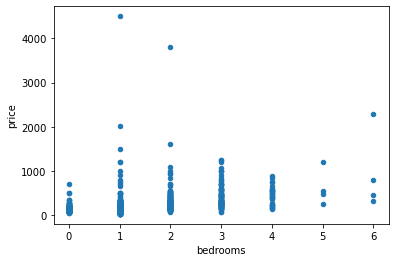

In [53]:
bed_price_df = testDF.select('bedrooms', 'price').toPandas()
bed_price_df.plot.scatter('bedrooms', 'price')

In [50]:
airbnbDF.select('price').summary().show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|              7146|
|   mean|213.30982367758187|
| stddev| 311.3754991591505|
|    min|              10.0|
|    25%|             100.0|
|    50%|             150.0|
|    75%|           10000.0|
|    max|           10000.0|
+-------+------------------+

